<a href="https://colab.research.google.com/github/adam-s/stocks_1/blob/main/buy_sell_1_bins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # import 
!pip install --quiet vectorbt
!pip install --quiet yfinance
!pip install --quiet --upgrade ta
!pip install --quiet s3fs
!pip install --quiet python-dotenv
!pip install --quiet tabulate
%load_ext dotenv

# load .env file containing credentials
import sys
# Check if this is colab
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount("/content/gdrive", False)
  %dotenv /content/gdrive/MyDrive/stocks/.env
else:
  %dotenv .env

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import requests
import time
from datetime import datetime
from dateutil.relativedelta import relativedelta
from itertools import combinations, product
import vectorbt as vbt
import yfinance as yf
import matplotlib.pyplot as plt
from tabulate import tabulate
import itertools
from collections import Counter
from sklearn import preprocessing, cluster, covariance
from tqdm.notebook import tqdm
import math
import os

In [ ]:
DATE_NOW = time.strftime("%Y-%m-%d")
BUCKET = 's3://robin-thee-hood-ranks'
HISTORICAL_PRICES_DATE = '2021-08-20'
SP500_CACHE = False
MACD_CACHE = False
# SP500_CACHE = True
# MACD_CACHE = True

In [ ]:
def fetch_SP500_companies(date=DATE_NOW):
  SP500_companies_path = f'{BUCKET}/{date}/SP500_companies.pickle'
  try:
    return pd.read_pickle(SP500_companies_path)
  except Exception as e:
    print(e)
  
  wiki_page = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies').text
  sp_data = pd.read_html(wiki_page)
  SP500_companies = pd.DataFrame(sp_data[0])
  SP500_companies.to_pickle(SP500_companies_path)
  return SP500_companies

In [ ]:
def calc_start_epoch(end=DATE_NOW, years=1):
  return datetime.strptime(end, '%Y-%m-%d') - relativedelta(years=years)

def format_date(datetime_value):
  if isinstance(datetime_value, str):
    return datetime_value
  return datetime.strftime(datetime_value, '%Y-%m-%d')

# https://stackoverflow.com/a/312464/494664
def chunks(lst, n):
  """Yield successive n-sized chunks from lst."""
  for i in range(0, len(lst), n):
      yield lst[i:i + n]

In [ ]:
def fetch_historical_prices(end=DATE_NOW, years=1, from_cache=True):
  CHUNK_SIZE=10
  start = calc_start_epoch(end, years)
  # The end is redundent however the file might be downloaded seperately out of 
  # context of the date file
  historical_prices_path = f'{BUCKET}/{end}/historical_prices_end_{format_date(end)}_years_{years}.pickle'
  if from_cache:
    try:
      return pd.read_pickle(historical_prices_path)
    except:
      pass
  SP500_companies = fetch_SP500_companies()
  symbols = [x.replace('.','-') for x in SP500_companies['Symbol']]
  historical_prices = pd.DataFrame(index=pd.DatetimeIndex([], name='Date'))
  chunked_symbols = chunks(symbols, CHUNK_SIZE)
  for chunk in tqdm(chunked_symbols,total=int(math.ceil(len(symbols)/CHUNK_SIZE))):
    print(','.join(chunk))
    while True:
      try:
        prices = yf.download(
          tickers=','.join(chunk),
          start=start,
          end=datetime.strptime(f'{end} 23:59:59.999999', '%Y-%m-%d %H:%M:%S.%f'), # Add the time to always get the latest for that day / otherwise it start at midnight or 00:00:00.000000
          threads=True,
          auto_adjust=True,
          proxy=os.environ['PROXY']
        )
      except Exception as e:
        print(e)
        continue
      break
    historical_prices = pd.concat([historical_prices, prices], axis=1)
  # Get the start and end date from the dataframe for consistancy
  historical_prices.to_pickle(historical_prices_path)
  return historical_prices

In [ ]:
# MACD
def get_macd(historical_prices=None, end=DATE_NOW, years=1, from_cache=True, limit=60):
  if not isinstance(historical_prices, pd.DataFrame):
    historical_prices = fetch_historical_prices(end=end, years=years, from_cache=from_cache)
    historical_prices = historical_prices['Close']
  # TODO: Use the business day pandas libraries to determin which is the last business day to use here
  end = format_date(historical_prices.last_valid_index())
  macd_best_fit_path = f'{BUCKET}/{end}/macd_best_fit_limit_{limit}_years_{years}_end_{end}.pickle'
  macd_buy_sell_path = f'{BUCKET}/{end}/macd_buy_sell_limit_{limit}_years_{years}_end_{end}.pickle'

  # limit the number of historical_prices used to calculate
  if limit > -1:
    historical_prices = historical_prices.iloc[-limit:]

  # No point loading the historical_prices if the finished macd is cached
  if from_cache:
    try:
      macd_best_fit_df = pd.read_pickle(macd_best_fit_path)
      macd_buy_sell_df = pd.read_pickle(macd_buy_sell_path)
      return macd_best_fit_df, macd_buy_sell_df
    except:
      pass

  # Run number crunching and then save to macd_path
  symbols = historical_prices.columns.unique()
  macd_best_fit_df = pd.DataFrame(columns=['macd_fast_window', 'macd_slow_window', 'macd_signal_window', 'total_return', 'symbol'], index=[])
  macd_buy_sell_df = pd.DataFrame(index=historical_prices.index)
  for symbol in symbols:
    print(symbol)
    price = historical_prices[symbol]
    
    # Define hyper-parameter space
    # 49 fast x 49 slow x 19 signal
    fast_windows, slow_windows, signal_windows = vbt.utils.params.create_param_combs(
        (product, (combinations, np.arange(2, 51, 1), 2), np.arange(2, 21, 1)))

    # Run MACD indicator
    macd_ind = vbt.MACD.run(
        price,
        fast_window=fast_windows,
        slow_window=slow_windows,
        signal_window=signal_windows
    )

    # Long when MACD is above zero AND signal
    entries = macd_ind.macd_above(0) & macd_ind.macd_above(macd_ind.signal)
    # Short when MACD is below zero OR signal
    exits = macd_ind.macd_below(0) | macd_ind.macd_below(macd_ind.signal)

    # Build portfolio
    pf = vbt.Portfolio.from_signals(
        price.vbt.tile(len(fast_windows)), entries, exits, fees=0.001, freq='1D')
    
    # Store the best result
    best_df = pf.total_return().sort_values(ascending=False).head(1)
    best_df = best_df.reset_index()
    best_df['symbol'] = symbol

    fast_window=best_df.loc[0]['macd_fast_window']
    slow_window=best_df.loc[0]['macd_slow_window']
    signal_window=best_df.loc[0]['macd_signal_window']

    best_entries = entries.xs((fast_window,slow_window,signal_window), level=['macd_fast_window', 'macd_slow_window', 'macd_signal_window'], axis=1)
    best_entries = best_entries.replace({True: 'Buy', False: 'Sell'})
    best_entries.columns = [symbol]
    print(best_entries.tail(10))

    macd_best_fit_df = macd_best_fit_df.append(best_df, ignore_index=True)
    macd_buy_sell_df = macd_buy_sell_df.merge(best_entries, on='Date')

  macd_best_fit_df = macd_best_fit_df.set_index('symbol')

  # Save dataframes to cache
  macd_best_fit_df.to_pickle(macd_best_fit_path)
  macd_buy_sell_df.to_pickle(macd_buy_sell_path)

  return macd_best_fit_df, macd_buy_sell_df

In [ ]:
#                      A        AAL  ...       ZION         ZTS
# Date                               ...                       
# 2021-07-22  150.300003  21.160000  ...  50.320000  200.539993
# 2021-07-23  151.639999  21.221500  ...  50.740002  202.639999
historical_prices = fetch_historical_prices(HISTORICAL_PRICES_DATE, from_cache=SP500_CACHE)
historical_prices = historical_prices['Close']
print(historical_prices)

#                    A       AAL       AAP  ...      ZBRA      ZION       ZTS
# Date                                      ...                              
# 2021-07-22  0.009063 -0.011215  0.004250  ...  0.004590 -0.025562  0.012624
# 2021-07-23  0.008915  0.002906  0.014884  ...  0.011600  0.008347  0.010472
prices_change = historical_prices.pct_change()
print(prices_change)

# Row wise rank the amount of change for each stock to compare to each other
#                 A    AAL    AAP   AAPL  ...    ZBH   ZBRA   ZION    ZTS
# Date                                    ...                            
# 2021-07-23  186.0  349.0   72.0  181.0  ...  174.0  119.0  204.0  140.0
prices_change_rank = prices_change.rank(axis=1, ascending=False)
prices_change_rank.dropna(how='all', inplace=True)
print(prices_change_rank)

macd_best_fit_df, macd_buy_sell_df = get_macd(historical_prices, from_cache=MACD_CACHE)

  0%|          | 0/51 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
2021-08-11  Sell
2021-08-12  Sell
2021-08-13  Sell
2021-08-16  Sell
2021-08-17  Sell
2021-08-18  Sell
2021-08-19   Buy
2021-08-20   Buy
CMA
             CMA
Date            
2021-08-09  Sell
2021-08-10   Buy
2021-08-11   Buy
2021-08-12   Buy
2021-08-13   Buy
2021-08-16  Sell
2021-08-17  Sell
2021-08-18  Sell
2021-08-19  Sell
2021-08-20  Sell
COO
             COO
Date            
2021-08-09  Sell
2021-08-10  Sell
2021-08-11   Buy
2021-08-12   Buy
2021-08-13   Buy
2021-08-16  Sell
2021-08-17  Sell
2021-08-18  Sell
2021-08-19  Sell
2021-08-20   Buy
COP
             COP
Date            
2021-08-09  Sell
2021-08-10  Sell
2021-08-11  Sell
2021-08-12  Sell
2021-08-13  Sell
2021-08-16  Sell
2021-08-17  Sell
2021-08-18  Sell
2021-08-19   Buy
2021-08-20  Sell
COST
            COST
Date            
2021-08-09   Buy
2021-08-10  Sell
2021-08-11  Sell
2021-08-12   Buy
2021-08-13   Buy
2021-08-16   Buy
2021-08-17  Sell
2021-08-18   Buy
2021-08-19  Se

In [ ]:
# This is the heart of the idea. The pattern in 5 days of rank change is going
# to be analyized. So the entire history is chunked into 6 day windows.
# 6 rows to analyze and the last row to fit.

#                 A    AAL    AAP   AAPL  ...    ZBH   ZBRA   ZION    ZTS
# Date                                    ...                            
# 2021-07-16  163.0  468.0  362.0  346.0  ...  141.0  274.0  489.0  192.0
# 2021-07-19  145.0  456.0   65.0  354.0  ...  294.0  305.0  443.0  150.0
# 2021-07-20  344.0    2.0  202.0  162.0  ...   77.0  167.0   16.0  325.0
# 2021-07-21  403.0   22.0  426.0  434.0  ...   81.0   73.0   67.0  458.0
# 2021-07-22   74.0  374.0  127.0   71.0  ...  283.0  122.0  488.0   48.0
# 2021-07-23  186.0  349.0   72.0  181.0  ...  174.0  119.0  204.0  140.0
#
# [7 rows x 505 columns]

# https://stackoverflow.com/a/48704557/494664
LOOK_BACK_LENGTH = 7
def rolling(df, window, step):
    count = 0
    df_length = len(df)
    while count <= (df_length -window):
        yield count, df[count:window+count]
        count += step

chunked = [chunk for offset, chunk in rolling(prices_change_rank, LOOK_BACK_LENGTH, 1)]

# chunked is a generator so don't iterate over them at once. It will take forever.
chunked[-1]

,AAP,ABBV,ABMD,ABT,ACN,ADBE,AES,AMD,ATVI,MMM,A,AFL,AKAM,ALB,ALGN,ALK,ALLE,APD,ARE,LNT,AAL,AEE,AEP,ALL,AMCR,AMZN,AXP,GOOG,GOOGL,MO,ABC,ADI,AIG,AME,AMGN,AMP,AMT,ANSS,APH,AWK,...,URI,VLO,VRSK,VRSN,VTR,V,VFC,VIAC,VMC,VNO,VRTX,VTRS,VZ,WAB,WRB,DIS,WAT,WBA,WDC,WEC,WELL,WFC,WM,WMT,WST,WHR,WLTW,WMB,WRK,WU,WY,WYNN,XEL,XLNX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-08-12,424.0,21.0,97.0,48.0,117.0,35.0,76.0,440.0,198.0,251.0,56.0,96.0,87.0,186.0,7.0,468.0,246.0,336.0,234.0,307.0,499.0,304.0,293.0,301.0,435.0,167.0,456.0,132.0,107.0,260.0,108.0,441.0,327.0,268.0,238.0,125.0,60.0,222.0,180.0,50.0,...,52.0,119.0,263.0,387.0,376.0,455.0,433.0,492.0,356.0,471.0,288.0,78.0,213.0,339.0,298.0,106.0,74.0,411.0,505.0,267.0,296.0,69.0,114.0,302.0,23.0,126.0,317.0,226.0,324.0,429.0,420.0,384.0,337.0,461.0,110.0,350.0,137.0,278.0,245.0,41.0
2021-08-13,445.0,119.0,302.0,228.0,159.0,172.0,440.0,2.0,458.0,346.0,127.0,303.0,396.0,358.0,475.0,466.0,132.0,111.0,182.0,128.0,494.0,57.0,99.0,298.0,100.0,324.0,449.0,272.0,191.0,70.0,277.0,89.0,30.0,274.0,129.0,312.0,60.0,315.0,255.0,101.0,...,488.0,451.0,149.0,343.0,81.0,193.0,192.0,483.0,443.0,140.0,313.0,273.0,184.0,291.0,74.0,69.0,73.0,284.0,44.0,139.0,12.0,457.0,197.0,205.0,55.0,116.0,406.0,370.0,409.0,223.0,360.0,471.0,196.0,173.0,200.0,48.0,307.0,170.0,408.0,103.0
2021-08-16,4.0,27.0,146.0,68.0,41.0,294.0,457.0,484.0,286.5,126.0,19.0,206.0,408.0,497.0,297.0,363.0,50.0,165.0,263.0,113.0,352.0,127.0,155.0,85.0,183.0,261.0,311.0,228.0,215.0,358.0,217.0,182.0,286.5,246.0,57.0,338.0,269.0,258.0,151.0,47.0,...,370.0,479.0,271.0,186.0,412.0,78.0,439.0,455.0,423.0,350.0,458.0,327.0,254.0,279.0,312.0,426.0,148.0,331.0,470.0,97.0,257.0,466.0,123.0,132.0,24.0,259.0,314.0,409.0,283.0,334.0,351.0,465.0,90.0,482.0,89.0,266.0,239.0,240.0,389.0,28.0
2021-08-17,420.0,35.0,25.0,53.0,106.0,201.0,315.0,142.0,240.0,349.0,254.0,177.0,197.0,494.0,355.0,481.0,139.0,162.0,103.0,129.0,423.0,87.0,113.0,341.0,301.0,389.0,245.0,321.0,325.0,98.0,63.0,460.0,314.0,299.0,143.0,290.0,29.0,378.0,230.0,163.0,...,392.0,376.0,52.0,82.0,241.0,206.0,476.0,26.0,323.0,227.0,3.0,291.0,97.0,226.0,86.0,402.0,223.0,151.5,320.0,127.0,92.0,353.0,179.0,155.0,145.0,488.0,335.0,231.0,407.0,212.0,435.0,406.0,116.0,151.5,272.0,178.0,51.0,398.0,330.0,50.0
2021-08-18,60.0,424.0,28.0,335.0,345.0,309.0,326.0,503.0,140.0,364.0,15.0,308.0,464.0,29.0,180.0,139.0,63.0,495.0,234.0,115.0,239.0,171.0,196.0,92.0,39.0,297.0,366.0,118.0,202.0,152.0,421.0,93.0,108.0,216.0,416.0,399.0,257.0,237.0,87.0,184.0,...,341.0,427.0,272.0,319.0,378.0,290.0,276.0,3.0,111.0,484.0,411.0,45.0,299.0,138.0,193.0,136.0,317.0,84.0,79.0,210.0,360.0,362.0,339.0,249.0,47.0,379.0,198.0,403.0,269.0,415.0,83.0,36.0,201.0,217.0,273.0,101.0,463.0,230.0,316.0,376.0
2021-08-19,186.0,153.0,122.0,57.0,81.0,36.0,312.0,202.0,177.0,320.0,9.0,341.0,130.0,429.0,136.0,409.0,208.0,275.0,184.0,223.0,441.0,192.0,127.0,258.0,18.0,296.0,425.0,201.0,212.0,225.0,150.0,146.0,399.0,302.0,360.0,389.0,25.0,80.0,196.0,91.0,...,463.0,485.0,21.0,51.0,386.0,236.0,276.0,434.0,315.0,316.0,219.0,294.0,256.0,470.0,26.0,345.0,96.0,432.0,451.0,156.0,272.0,401.0,64.0,137.0,89.0,297.0,224.0,324.0,414.0,361.0,191.0,495.0,82.0,112.0,235.0,281.0,255.0,99.0,346.0,48.0
2021-08-20,257.0,220.0,2.0,296.0,96.0,81.0,16.0,187.0,479.0,474.0,354.0,214.0,102.0,15.0,361.0,242.0,495.0,498.0,188.0,131.0,496.0,410.0,222.0,321.0,12.0,325.0,306.0,134.0,103.0,297.0,366.0,429.0,128.0,346.0,459.0,299.0,270.0,108.0,300.0,105.0,...,461.0,425.0,194.0,275.0,407.0,430.0,250.0,379.0,405.0,404.0,317.0,447.0,356.0,348.0,146.0,141.0,478.0,77.0,213.0,253.0,382.0,333.0,195.0,190.0,273.0,203.0,39.0,258.0,100.0,448.0,225.0,464.0,237.0,111.0,162.0,330.0,184.0,79.0,99.0,347.0


In [ ]:
# def tokenizer(chunk):
#   token=[]
#   for index, value in enumerate(chunk):
#     if index == chunk.size - 1:
#       break;
#     if value < chunk.iloc[index+1]:
#       token.append('gt')
#     elif value > chunk.iloc[index+1]:
#       token.append('lt')
#     else:
#       token.append('eq')
#   return ":".join(token)

# Show mean change
# change_day_mean = prices_change.mean(axis=1)
# change_day_mean.dropna(inplace=True)
# print(change_day_mean.tail(30))

# Print tokens in order
# day_avg = [{'date': format_date(chunk.last_valid_index()), 'token': tokenizer(chunk)} for offset, chunk in rolling(change_day_mean,4,1)]
# day_avg_df = pd.DataFrame(day_avg)
# day_avg_df.set_index('date', inplace=True)
# day_avg_df = day_avg_df.reset_index().set_index(['token']).sort_values(['token'])
# day_avg_df.index.unique()
# print(day_avg_df.sort_values(by='date', ascending=True))

# Chart the changes
# fig = change_day_mean[-60:].plot(figsize=(18,9), marker='o')
# fig.axhline(y=0, color='r', linestyle='-')
# fig.axhline(y=0.01, color='k', linestyle=':')
# fig.axhline(y=-0.01, color='k', linestyle=':')
# fig.axhline(y=change_day_mean[-60:].mean(), color='g', linestyle='--')
# plt.show()

Date
2021-04-15         NaN
2021-04-16   -0.003480
2021-04-19   -0.009313
2021-04-20   -0.002605
2021-04-21    0.021454
                ...   
2021-08-16    0.000633
2021-08-17   -0.008110
2021-08-18   -0.002288
2021-08-19    0.007555
2021-08-20    0.010023
Name: delta_shift_1, Length: 90, dtype: float64


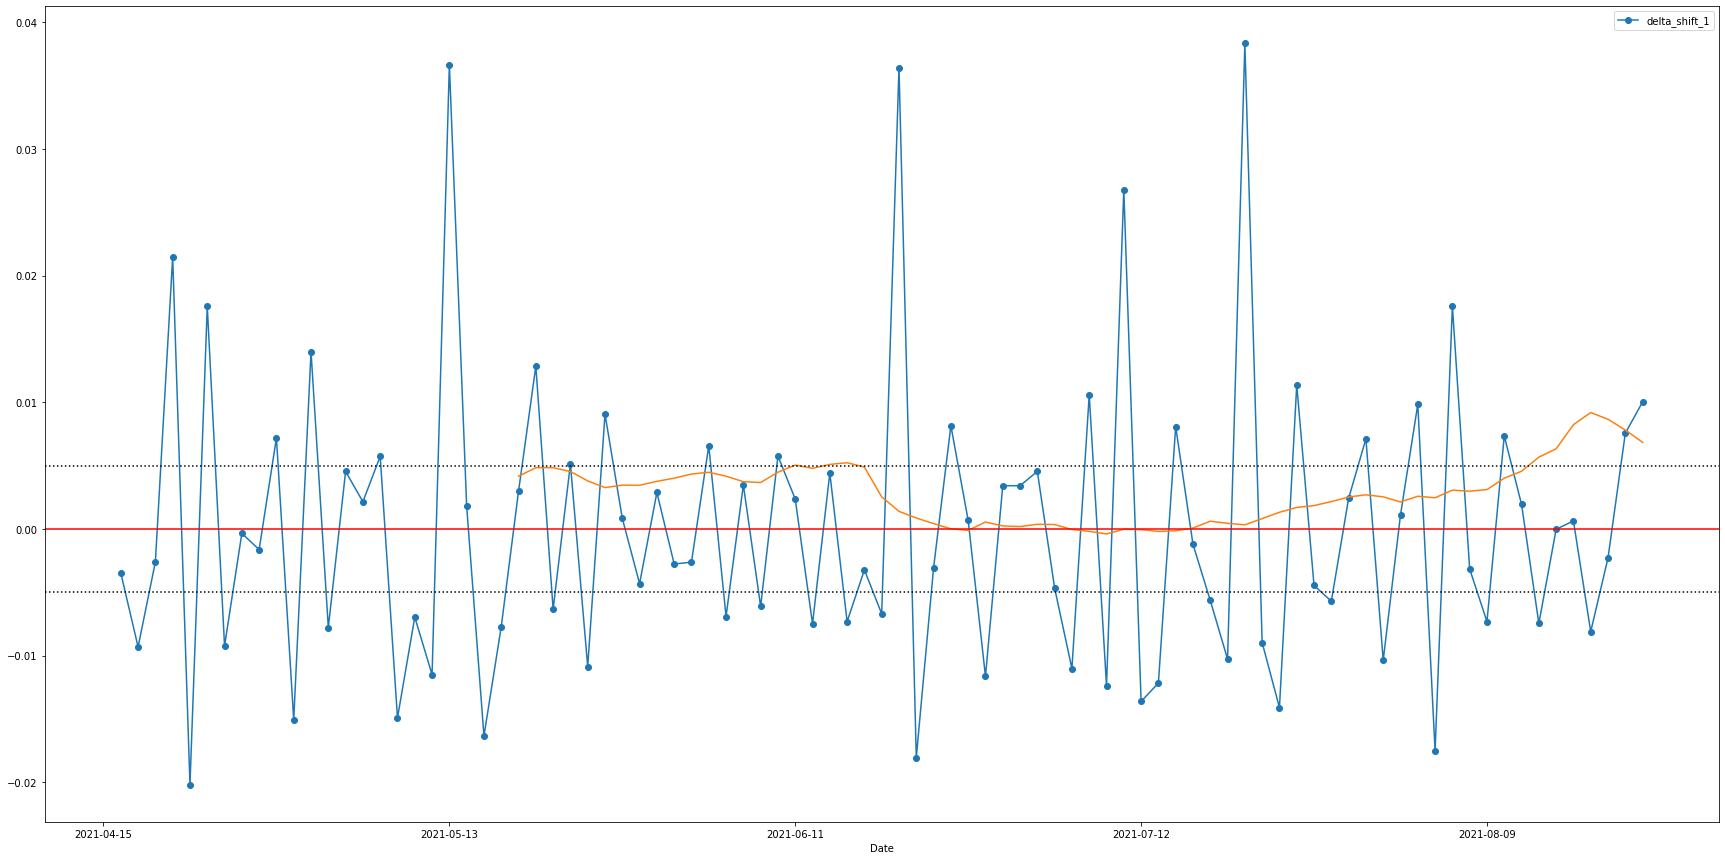

In [ ]:
# Show mean change row wise of the price change. This should be similar to 
# unweighted versions of the S&P index. Aggrigation of all the percentage change
# in price from the previous day of all 505 stocks in the S&P.
# Date
# 2021-07-19   -0.018523
# 2021-07-20    0.019795
# 2021-07-21    0.010819
# 2021-07-22   -0.003285
# 2021-07-23    0.005807
# dtype: float64

change_day_mean = prices_change.mean(axis=1) # Note: don't confuse price change with rank somewhere 1 - 505 change
change_day_mean.dropna(inplace=True)

# Graph how much it changes day to day. The mean is usually right above zero.
change = pd.DataFrame(change_day_mean[-90:], columns=['delta'])
change['delta_shift_1'] = change['delta'] - change['delta'].shift(1)
change.index = change.index.map(format_date)
print(change['delta_shift_1'])
change['delta_rolling'] = change['delta'].rolling(20).mean().rolling(6).mean() * 5
fig = change[['delta_shift_1']].plot(figsize=(30,15), marker='o')
fig.plot(change['delta_rolling'])
fig.axhline(y=0, color='r', linestyle='-')
# fig.axhline(y=0.01, color='k', linestyle=':')
fig.axhline(y=0.005, color='k', linestyle=':')
fig.axhline(y=-0.005, color='k', linestyle=':')
plt.show()

# If below 0.00 chance of going positive is
# 1 in a row = 62.5%
# 2 in a row = 66.0%
# 3 in a row = 100.0%
#
# 1 or 2 in a row = 84%

# If above 0.00 chance of going negative is
# 1 in a row = 67%
# 2 in a row = 57%
# 3 in a row = 100%

In [ ]:
# This is an alternative way to group changes by how many consecutive days the 
# change in price is positive or negative. It is not used for anything further.
def pos_neg_count_token():
  change_df = pd.DataFrame(change_day_mean, columns=['delta'])
  change_df['delta_shift_1'] = change_df['delta'] - change_df['delta'].shift(1)
  count = 1
  previous_direction = None
  change_force_df = pd.DataFrame(columns=['date', 'token'])
  for index, value in change_df['delta_shift_1'].iteritems():
    direction = 'p' if value >= 0 else 'n'
    if direction == previous_direction:
      count += 1
    else:
      previous_direction = direction
      count = 1
    if value > 3: # Just set a max of three
      value = 3
    token = f"{direction}{count}"
    change_force_df = change_force_df.append({'date': format_date(index), 'token': token}, ignore_index=True)

  change_force_df.set_index('token', inplace=True)
  change_force_df.sort_values(by='date', ascending=True, inplace=True)
  change_force_df.sort_values(by=['token', 'date'], ascending=True, inplace=True)
  change_force_df

# pos_neg_count_token()

In [ ]:
def tokenizer(chunk):
  # token=[]
  # for index, value in enumerate(chunk):
  #   if index == chunk.size - 1:
  #     break;
  #   if value < chunk.iloc[index+1]:
  #     token.append('gt')
  #   elif value > chunk.iloc[index+1]:
  #     token.append('lt')
  #   else:
  #     token.append('eq')
  # return ":".join(token)
  token=[]
  for index, value in enumerate(chunk):
    if index == chunk.size - 1:
      break;
    # if 0 < chunk.iloc[index+1]:
    #   if chunk.iloc[index+1] > 0.0075:
    #     token.append('ggt')
    #   else:
    #     token.append('gt')
    # elif 0 > chunk.iloc[index+1]:
    #   if chunk.iloc[index+1] < -0.0075:
    #     token.append('llt')
    #   else:
    #     token.append('lt')
    # else:
    #   token.append('eq')
    token.append('eq')
  return ":".join(token)

change_day_mean = prices_change.mean(axis=1)
change_day_mean.dropna(inplace=True)

# Graph how much it changes day to day. The mean is usually right above zero.
change = pd.DataFrame(change_day_mean, columns=['delta'])
change['delta_shift_1'] = change['delta'] - change['delta'].shift(1)

day_avg = [{'date': format_date(chunk.last_valid_index()), 'token': tokenizer(chunk)} for offset, chunk in rolling(change['delta_shift_1'],2,1)]
day_avg_df = pd.DataFrame(day_avg)
day_avg_df.set_index('date', inplace=True)
day_avg_df = day_avg_df.reset_index().set_index(['token']).sort_values(['token'])
day_avg_df.index.unique()
day_avg_df = day_avg_df.sort_values(by=['token', 'date'], ascending=True)

# TODO: Create a way to set the minimum limit based on how many tokens exist in the dataset
# Slice day_avg_df by the day ordered by date. Count how many tokens exist. Maybe
# create a list of token count based on date between date and today. This will give 
# higher weight, influence, to more recent data or market behavior when the limit size is smaller
token_counts = day_avg_df.index.value_counts()
todays_token = day_avg_df.sort_values(by='date').last_valid_index()
print(todays_token, " count:", token_counts[todays_token])

eq  count: 251


In [ ]:
# For analysis group chunks whether the trend of the change in price is down or up
# over 3 days
def render_op_str(ops):
  final_str = ''
  last_op_index = 0
  for i, op in enumerate(ops):
    if op == 'lt':
      final_str += f'df.iloc[{i}] < '
      last_op_index = i
    elif op == 'gt':
      final_str += f'df.iloc[{i}] > '
      last_op_index = i
    else:
      continue
  if final_str[-3:] == ' < ' or final_str[-3:] == ' > ':
    final_str += f'df.iloc[{last_op_index + 1}]'
  return ops, final_str

# ops = ['lt','gt','noop'] # It is expensive to consider days that go up or down
ops = ['lt','gt'] # Remove the noop from ops
# No matter what the final one gets added so its -1 plus another -1 for the testing following day
ops_combo = list(itertools.product(ops, repeat=(LOOK_BACK_LENGTH-2)))
ops_combo = [ops for ops in ops_combo if Counter(ops)['noop'] < (LOOK_BACK_LENGTH-2)]
operations = [render_op_str(ops) for ops in ops_combo]

In [ ]:
# https://jakevdp.github.io/PythonDataScienceHandbook/03.12-performance-eval-and-query.html
# results = pd.DataFrame(index=[operation_str for _, operation_str in operations])
# results.index.name = 'operation'
limit = 1

# Create a data frame to store the results indexed by operation groups
results = pd.DataFrame(index=[operation_str for _, operation_str in operations])
results.index.name = 'operation'

# Iterate over each of the change rank comparing the first to the operation and using
# the last row to fit the outcome.
for i, df in enumerate(chunked[-limit:]):
  print(f'Processing {i + 1} out of {len(chunked[-limit:])}')

  #              MRNA   FOXA    FOX   AMAT   ALLE  ...    CZR      F   PENN    NOV  OGN
  # Date                                           ...                                 
  # 2021-03-09   22.0  496.0  494.0    6.0  416.0  ...  377.0  314.0   23.0  502.0  NaN
  # 2021-03-10  448.0   60.0  150.0  465.0  214.0  ...    9.0   66.0    3.0   23.0  NaN
  # 2021-03-11    3.0  183.0  165.0   36.0  427.0  ...   91.0  416.0    7.0  446.0  NaN
  # 2021-03-12  492.0   60.0  147.0  491.0   81.0  ...  356.0   10.0  382.0  260.0  NaN
  # 2021-03-15   10.0  401.0  350.0  312.0  287.0  ...  307.0  473.0   14.0  195.0  NaN
  # 2021-03-16    1.0    2.0    3.0    4.0    5.0  ...  501.0  502.0  503.0  504.0  NaN
  # 2021-03-17  503.0  494.0  488.0  136.0  163.0  ...  270.0   94.0  308.0   16.0  NaN
  #
  # [7 rows x 505 columns]
  
  # Sort the data frame by the second to last index. The last index is use to fit
  last_index = format_date(df.last_valid_index())
  df = df.sort_values(format_date(df.index[-2]), axis=1)

  # Empty DataFrame
  # Columns: [(2021-03-17, top),
  #           (2021-03-17, bottom),
  #           (2021-03-17, normal),
  #           (2021-03-17, symbols),
  #           (2021-03-17, buy_mean),
  #           (2021-03-17, buy_top_5_mean),
  #           (2021-03-17, buy_bottom_5_mean),
  #           (2021-03-17, sell_mean),
  #           (2021-03-17, sell_top_5_mean),
  #           (2021-03-17, sell_bottom_5_mean)]
  # Index: []

  # Create an empty data frame to store all the price changes for the operation and other features like MACD
  columns_agg = ['top', 'bottom', 'normal', 'symbols','buy_mean','buy_top_10_mean','buy_bottom_10_mean','sell_mean','sell_top_10_mean','sell_bottom_10_mean']
  columns = pd.MultiIndex.from_product([[last_index], columns_agg])
  change_mean = pd.DataFrame(columns=columns)

  # MACD for the day
  macd = macd_buy_sell_df.iloc[-2]
  buy_symbols = macd[macd.values == 'Buy'].index.values
  sell_symbols = macd[macd.values == 'Sell'].index.values

  # Iterate over every less than / greater than operation sequence to find stock rank changes
  # that meet the criteria.
  #
  # prices_change is the data frame that contains the percentage change in price for each stock
  # from the previous day
  for operation, operation_str in operations:
    # ('lt', 'lt', 'lt', 'lt', 'gt')
    mask = pd.eval(operation_str)

    #               PEP     EW   FISV    STT     DD    PKG   ISRG
    # Date                                                       
    # 2021-03-09  248.0  105.0  175.0  121.0  200.0  159.0   81.0
    # 2021-03-10  264.0  235.0  246.0  168.0  207.0  319.0   93.0
    # 2021-03-11  347.0  309.0  282.0  240.0  272.0  400.0  128.0
    # 2021-03-12  358.0  451.0  344.0  308.0  313.0  455.0  303.0
    # 2021-03-15  379.0  462.0  389.0  397.0  422.0  489.0  366.0
    # 2021-03-16   68.0  135.0  144.0  163.0  164.0  273.0  301.0
    # 2021-03-17  355.0  444.0  374.0  121.0   57.0  156.0  351.0
    consecutive_df = df.loc[:, mask]

    # Buy
    buy = consecutive_df.loc[:, macd == 'Buy']
    buy_mean = prices_change.loc[last_index, buy.columns].mean()
    # print('buy        : ', buy_mean)

    # Buy top
    buy_top_10 = buy.iloc[:,:10]
    buy_top_10_mean = prices_change.loc[last_index, buy_top_10.columns].mean()
    # print('buy top    : ', buy_top_10_mean)

    # Buy bottom
    buy_bottom_10 = buy.iloc[:,-10:]
    buy_bottom_10_mean = prices_change.loc[last_index, buy_bottom_10.columns].mean()
    # print('buy bottom : ', buy_bottom_10_mean)

    # Sell
    sell = consecutive_df.loc[:, macd == 'Sell']
    sell_mean = prices_change.loc[last_index, sell.columns].mean()
    # print('sell       : ', sell_mean)

    # Sell top
    sell_top_10 = sell.iloc[:,:10]
    sell_top_10_mean = prices_change.loc[last_index, sell_top_10.columns].mean()
    # print('sell top   : ', sell_top_10_mean)

    # Sell bottom
    sell_bottom_10 = sell.iloc[:,-10:]
    sell_bottom_10_mean = prices_change.loc[last_index, sell_bottom_10.columns].mean()
    # print('sell bottom: ', sell_bottom_10_mean)

    top_10 = consecutive_df.iloc[:,:10]
    top_10_mean = prices_change.loc[last_index, top_10.columns].mean()
    # print('top        : ', top_10_mean)

    bottom_10 = consecutive_df.iloc[:,-10:]
    bottom_10_mean = prices_change.loc[last_index, bottom_10.columns].mean()
    # print('bottom     : ', bottom_10_mean)

    mean = prices_change.loc[last_index, consecutive_df.columns].mean()
    # print('normal     : ', mean)
    # print()
    # change_mean = change_mean.append({'operation': operation_str, last_index: mean}, ignore_index=True)
    symbols = ",".join(consecutive_df.columns)
    change_values = {
        (last_index, 'top'): top_10_mean,
        (last_index, 'bottom'): bottom_10_mean,
        (last_index, 'normal'): mean,
        (last_index, 'buy_mean'): buy_mean,
        (last_index, 'buy_top_10_mean'): buy_top_10_mean,
        (last_index, 'buy_bottom_10_mean'): buy_bottom_10_mean,
        (last_index, 'sell_mean'): sell_mean,
        (last_index, 'sell_top_10_mean'): sell_top_10_mean,
        (last_index, 'sell_bottom_10_mean'): sell_bottom_10_mean,
        (last_index, 'symbols'): symbols
    }
    change_df = pd.DataFrame(change_values, columns=columns, index=[operation_str])
    # change_mean_multi = change_mean_multi.append(change_df, ignore_index=True)

    change_mean = pd.concat([change_mean, change_df])
    # Add two more result data frames for macd and top / bottom 5
  # change_mean.set_index('operation', inplace=True)
  # results = results.merge(change_mean, on='operation')

  results = pd.concat([results, change_mean], axis=1)

results.columns = pd.MultiIndex.from_tuples(results.columns, names=['date', 'type'])

# date                                               2021-03-17  ...         2021-07-23
# type                                                      top  ... sell_bottom_5_mean
# operation                                                      ...                   
# df.iloc[0] < df.iloc[1] < df.iloc[2] < df.iloc[...   0.003363  ...           0.009186
# df.iloc[0] < df.iloc[1] < df.iloc[2] < df.iloc[...  -0.006610  ...           0.015698

# [32 rows x 900 columns]

# Remember the results are if that operation is met the average of the change of all the
# stocks for the NEXT day
print(results)

Processing 1 out of 1
date                                               2021-08-20  ...                    
type                                                      top  ... sell_bottom_10_mean
operation                                                      ...                    
df.iloc[0] < df.iloc[1] < df.iloc[2] < df.iloc[...   0.034761  ...                 NaN
df.iloc[0] < df.iloc[1] < df.iloc[2] < df.iloc[...   0.005728  ...          0.00407604
df.iloc[0] < df.iloc[1] < df.iloc[2] < df.iloc[...   0.008684  ...           0.0150155
df.iloc[0] < df.iloc[1] < df.iloc[2] < df.iloc[...   0.005310  ...           0.0040901
df.iloc[0] < df.iloc[1] < df.iloc[2] > df.iloc[...  -0.001674  ...         0.000358134
df.iloc[0] < df.iloc[1] < df.iloc[2] > df.iloc[...   0.005294  ...          0.00370436
df.iloc[0] < df.iloc[1] < df.iloc[2] > df.iloc[...   0.014926  ...          0.00627145
df.iloc[0] < df.iloc[1] < df.iloc[2] > df.iloc[...   0.014420  ...          0.00936454
df.iloc[0] < df.iloc[

In [ ]:
# Manually cache the results perhaps integrate it later if useful
operation_results_path = f'{BUCKET}/{HISTORICAL_PRICES_DATE}/operation_results_limit_{limit}_date_{HISTORICAL_PRICES_DATE}.pickle'
results.to_pickle(operation_results_path)

In [ ]:
# Manually cache the results perhaps integrate it later if useful
operation_results_path = f'{BUCKET}/{HISTORICAL_PRICES_DATE}/operation_results_limit_{limit}_date_{HISTORICAL_PRICES_DATE}.pickle'
results = pd.read_pickle(operation_results_path)


In [ ]:
def day_avg():
  change_day_mean = prices_change.mean(axis=1)
  # offset
  # 503
  
  # chunk
  # Date
  # 2021-07-20    0.019795
  # 2021-07-21    0.010819
  # 2021-07-22   -0.003285
  # 2021-07-23    0.005807
  # dtype: float64
  
  # {'date': chunk.last_valid_index(), 'value': chunk.sum()}
  # {'date': Timestamp('2021-07-23 00:00:00'), 'value': 0.03313564685186486}
  day_avg = [{'date': chunk.last_valid_index(), 'value': chunk.sum()} for offset, chunk in rolling(change_day_mean,4,1)]
  day_avg_df = pd.DataFrame(day_avg)
  day_avg_df.set_index('date', inplace=True)
  day_avg_df.hist(bins=10)
  bins = pd.cut(day_avg_df['value'], bins=[x / 100.0 for x in range(-22, 22, 4)])
  day_avg_df = day_avg_df.merge(bins, right_index=True, left_index=True)
  day_avg_df.set_index(['value_y',day_avg_df.index]).groupby('value_y').size()

# day_avg()

In [ ]:
def results_columns_levels():
  print(results.columns.levels[1])

# results_columns_levels()

In [ ]:
column_names = [
                # ('bottom',True),
                # ('top',False),
                # ('normal',False),
                ('buy_mean',False),
                # ('buy_top_10_mean',False),
                # ('buy_bottom_10_mean',False),
                ('sell_mean',True),
                # ('sell_top_10_mean',True),
                # ('sell_bottom_10_mean',True)
                ]

df = prices_change_rank[-(LOOK_BACK_LENGTH-1):]
last_index = format_date(df.last_valid_index())
macd = macd_buy_sell_df.loc[last_index]
df = df.sort_values(last_index, axis=1)

processed_df = pd.DataFrame(columns=['token', 'name', 'operation', 'mean', 'symbols'])

todays_token = day_avg_df.sort_values(by='date').last_valid_index()

for token in day_avg_df.index.unique():
  if token != todays_token:
    continue
    
  dates = np.hstack(day_avg_df.loc[[token]].values)
  # Might be off by one ???
  results_by_token = results[results.columns.levels[0].intersection(dates)]
  for name, ascending in column_names:
    try:
      results_type = results_by_token.loc[:, (slice(None), name)].droplevel(1, axis=1)
      final_mean = results_type.mean(axis=1)
      # final_mean.sort_values(inplace=True, ascending=ascending)
      final_mean.sort_values(inplace=True, ascending=False)
      final_mean = pd.DataFrame(final_mean)
      final_mean.columns = ['mean']
      final_mean = final_mean.round(7)
      operations = final_mean.index.values
      for operation in operations:
        mask = pd.eval(operation)
        buy_or_sell = 'Sell' if ascending==True else 'Buy'
        today = df.loc[last_index] if name == 'normal' else df.loc[last_index, macd == buy_or_sell]
        today = today.loc[mask]
        symbols = []
        if today.index.size != 0: # make sure that index has symbols available
          if "bottom" in name:
            slice_index = (max(-10,-today.index.size))
            symbols = today.index[slice_index:]
          elif "top" in name:
            slice_index = (min(10,today.index.size))
            symbols = today.index[:slice_index]
          else:
            symbols = today.index
        symbols = ",".join(symbols)
        mean = final_mean.loc[operation, 'mean']
        processed_row_series = pd.Series([token, name, operation, mean, symbols], index=processed_df.columns)
        processed_df = processed_df.append(processed_row_series, ignore_index=True)
    except Exception as e:
      print(e)
processed_df.set_index(['token', 'name', 'operation'], inplace=True)

In [ ]:
def print_operation_table(token):
  df = processed_df.loc[token]
  df = df.reset_index()
  df['count'] = df['operation'].str.count('>')
  df = df.sort_values(by=['count', 'operation', 'name'], ascending=True)
  df = df.sort_values(by=['mean'], ascending=False)
  print(tabulate(df, headers=[token,'name', 'operation','mean','symbols','count'], tablefmt='psql'))
  print(df['mean'].mean())

todays_token = day_avg_df.sort_values(by='date').last_valid_index()

# for token in processed_df.index.levels[0]:
#   print_operation_table(token)

print_operation_table(todays_token)
print(todays_token)

+------+-----------+-----------------------------------------------------------------------------+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|   eq | name      | operation                                                                   |        mean | symbols                                                                                                                                                 |   count |
|------+-----------+-----------------------------------------------------------------------------+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------+---------|
|    0 | buy_mean  | df.iloc[0] < df.iloc[1] < df.iloc[2] < df.iloc[3] < df.iloc[4] < df.iloc[5] |   0.0347606 |                                                         

In [ ]:
# from IPython.display import Javascript
# def open_tickers(symbols):
#     url = f'https://finance.yahoo.com/quotes/{",".join(symbols)}/view/v1'
#     display(Javascript('window.open("{url}");'.format(url=url)))

most_recent_deltas = chunked[-1]
def print_operation_deltas(token):
  df = processed_df.loc[token]
  df = df.reset_index()
  df['count'] = df['operation'].str.count('>')
  df = df.sort_values(by=['count', 'operation', 'name'], ascending=True)
  for index, row in df.iterrows():
    symbol_cluster = row['symbols'].split(',')
    operations_to_check = [
                           'df.iloc[0] < df.iloc[1] > df.iloc[2] > df.iloc[3] < df.iloc[4] < df.iloc[5]',
                           'df.iloc[0] > df.iloc[1] < df.iloc[2] < df.iloc[3] > df.iloc[4] > df.iloc[5]',
    ]
    if len(symbol_cluster) > 1:
      print(f"{row['name']} | {row['operation']} | > count = {row['operation'].count('>')}")
      mean = pd.DataFrame(most_recent_deltas[symbol_cluster].mean(), columns=[most_recent_deltas.last_valid_index()]).T
      # print(tabulate(np.floor(mean), headers=mean.columns, tablefmt='psql'))
      vega =  pd.DataFrame(most_recent_deltas[symbol_cluster].diff().abs().sum(), columns=[most_recent_deltas.last_valid_index()]).T
      # vega = vega.sort_values(by=vega.last_valid_index(), axis=1)
      # print(tabulate(vega, headers=vega.columns, tablefmt='psql'))
      diff = (vega / mean) * 100
      # print(tabulate(np.floor(diff), headers=diff.columns, tablefmt='psql'))

      # mask_top = mean.iloc[0] < 250
      # mask_bottom = mean.iloc[0] >= 250
      # tops = vega.loc[:,mask_top.index[mask_top]]
      # bottoms = vega.loc[:,mask_bottom.index[mask_bottom]]
      # if not tops.empty:
      #   vega_symbol_string = tops.sort_values(by=tops.last_valid_index(), axis=1)
      #   print(f'tops:    https://finance.yahoo.com/quotes/{",".join(vega_symbol_string)}/view/v1')
      # if not bottoms.empty:
      #   vega_symbol_string = bottoms.sort_values(by=bottoms.last_valid_index(), axis=1)
      #   print(f'bottoms: https://finance.yahoo.com/quotes/{",".join(vega_symbol_string)}/view/v1')

      # symbol_string = diff.sort_values(by=diff.last_valid_index(), axis=1)
      mask_bottom = vega.iloc[0] >= 0
      bottoms = vega.loc[:,mask_bottom.index[mask_bottom]]
      if not bottoms.empty:
        vega_symbol_string = bottoms.sort_values(by=bottoms.last_valid_index(), axis=1)
        print(tabulate(vega_symbol_string, headers=vega_symbol_string.columns, tablefmt='psql'))
        print(f'https://finance.yahoo.com/quotes/{",".join(vega_symbol_string)}/view/v1')
        # open_tickers(vega_symbol_string)

      if row['operation'] in operations_to_check:
        print('^' * 200)
      print()

todays_token = day_avg_df.sort_values(by='date').last_valid_index()

# for token in processed_df.index.levels[0]:
#   print_operation_table(token)

print_operation_deltas(todays_token)
print(todays_token)

sell_mean | df.iloc[0] < df.iloc[1] < df.iloc[2] < df.iloc[3] < df.iloc[4] > df.iloc[5] | > count = 1
+---------------------+-------+--------+
|                     |   MCD |   ILMN |
|---------------------+-------+--------|
| 2021-08-20 00:00:00 |   262 |    975 |
+---------------------+-------+--------+
https://finance.yahoo.com/quotes/MCD,ILMN/view/v1

buy_mean | df.iloc[0] < df.iloc[1] < df.iloc[2] < df.iloc[3] > df.iloc[4] < df.iloc[5] | > count = 1
+---------------------+-------+--------+-------+-------+--------+-------+
|                     |   PLD |   NDAQ |   MAA |   PEP |   MNST |   CHD |
|---------------------+-------+--------+-------+-------+--------+-------|
| 2021-08-20 00:00:00 |   472 |    650 |   660 |   924 |   1251 |  1416 |
+---------------------+-------+--------+-------+-------+--------+-------+
https://finance.yahoo.com/quotes/PLD,NDAQ,MAA,PEP,MNST,CHD/view/v1

sell_mean | df.iloc[0] < df.iloc[1] < df.iloc[2] < df.iloc[3] > df.iloc[4] < df.iloc[5] | > count = 1
+

In [ ]:
most_recent_deltas = chunked[-1]
def print_operation_deltas(token):
  vegas_all = pd.DataFrame()
  vegas_sell = pd.DataFrame()
  vegas_buy = pd.DataFrame()
  df = processed_df.loc[token]
  df = df.sort_values(by='mean', ascending=False)
  df = df.reset_index()
  for index, row in df.iterrows():
    symbol_cluster = row['symbols'].split(',')
    if len(symbol_cluster) > 1:
      print()
      print(f"{row['name']} | {row['operation']}")
      print(row['symbols'])
      print(tabulate(most_recent_deltas[symbol_cluster], headers=symbol_cluster, tablefmt='psql'))
      print(tabulate(round(most_recent_deltas[symbol_cluster].diff() * -1), headers=symbol_cluster, tablefmt='psql'))
      vega =  pd.DataFrame(most_recent_deltas[symbol_cluster].diff().abs().sum(), columns=[most_recent_deltas.last_valid_index()]).T
      print(tabulate(vega, headers=vega.columns, tablefmt='psql'))
      print(f'https://finance.yahoo.com/quotes/{",".join(symbol_cluster)}/view/v1')


      vegas_all = pd.concat([vegas_all, vega.T])
      if 'buy' in row['name']:
        vegas_buy = pd.concat([vegas_buy, vega.T])
      if 'sell' in row['name']:
        vegas_sell = pd.concat([vegas_sell, vega.T])
  print('all')
  vegas_all = vegas_all.sort_values(by=most_recent_deltas.last_valid_index())
  vegas_all = vegas_all.T
  print(tabulate(vegas_all,headers=vegas_all.columns,tablefmt='psql'))
  print(f'https://finance.yahoo.com/quotes/{",".join(vegas_all.columns.values)}/view/v1')

  print('sell')
  vegas_sell = vegas_sell.sort_values(by=most_recent_deltas.last_valid_index())
  vegas_sell = vegas_sell.T
  print(tabulate(vegas_sell,headers=vegas_sell.columns,tablefmt='psql'))
  print(f'https://finance.yahoo.com/quotes/{",".join(vegas_sell.columns.values)}/view/v1')

  print('buy')
  vegas_buy = vegas_buy.sort_values(by=most_recent_deltas.last_valid_index())
  vegas_buy = vegas_buy.T
  print(tabulate(vegas_buy,headers=vegas_buy.columns,tablefmt='psql'))
  print(f'https://finance.yahoo.com/quotes/{",".join(vegas_buy.columns.values)}/view/v1')

  
todays_token = day_avg_df.sort_values(by='date').last_valid_index()

# for token in processed_df.index.levels[0]:
#   print_operation_table(token)

print_operation_deltas(todays_token)
print(todays_token)


buy_mean | df.iloc[0] > df.iloc[1] > df.iloc[2] > df.iloc[3] < df.iloc[4] < df.iloc[5]
PSA,CSX,IDXX,VMC
+---------------------+-------+-------+--------+-------+
|                     |   PSA |   CSX |   IDXX |   VMC |
|---------------------+-------+-------+--------+-------|
| 2021-08-12 00:00:00 |    70 | 154   |     26 |   356 |
| 2021-08-13 00:00:00 |   292 | 387   |    353 |   443 |
| 2021-08-16 00:00:00 |    86 | 286.5 |    197 |   423 |
| 2021-08-17 00:00:00 |    84 | 210   |     91 |   323 |
| 2021-08-18 00:00:00 |    42 |  49   |     75 |   111 |
| 2021-08-19 00:00:00 |   133 | 311   |    132 |   315 |
| 2021-08-20 00:00:00 |   278 | 316   |    402 |   405 |
+---------------------+-------+-------+--------+-------+
+---------------------+-------+-------+--------+-------+
|                     |   PSA |   CSX |   IDXX |   VMC |
|---------------------+-------+-------+--------+-------|
| 2021-08-12 00:00:00 |   nan |   nan |    nan |   nan |
| 2021-08-13 00:00:00 |  -222 |  -233 | 

In [ ]:
def change_force():
  column_names = [
                  # ('bottom',True),
                  # ('top',False),
                  ('normal',False),
                  # ('buy_mean',False),
                  # ('buy_top_10_mean',False),
                  # ('buy_bottom_10_mean',False),
                  # ('sell_mean',True),
                  # ('sell_top_10_mean',True),
                  # ('sell_bottom_10_mean',True)
                  ]

  df = prices_change_rank[-(LOOK_BACK_LENGTH-1):]
  last_index = format_date(df.last_valid_index())
  macd = macd_buy_sell_df.loc[last_index]
  df = df.sort_values(last_index, axis=1)

  processed_df = pd.DataFrame(columns=['token', 'name', 'operation', 'mean', 'symbols'])
  for token in change_force_df.index.unique():
    dates = np.hstack(change_force_df.loc[[token]].values)
    results_by_token = results[results.columns.levels[0].intersection(dates)]
    for name, ascending in column_names:
      try:
        results_type = results_by_token.loc[:, (slice(None), name)].droplevel(1, axis=1)
        final_mean = results_type.mean(axis=1)
        final_mean.sort_values(inplace=True, ascending=ascending)
        final_mean = pd.DataFrame(final_mean)
        final_mean.columns = ['mean']
        final_mean = final_mean.round(10)
        operations = final_mean.index.values
        for operation in operations:
          mask = pd.eval(operation)
          buy_or_sell = 'Sell' if ascending==True else 'Buy'
          today = df.loc[last_index] if name == 'normal' else df.loc[last_index, macd == buy_or_sell]
          today = today.loc[mask]
          symbols = []
          if today.index.size != 0: # make sure that index has symbols available
            if "bottom" in name:
              slice_index = (max(-5,-today.index.size))
              symbols = today.index[slice_index:]
            elif "top" in name:
              slice_index = (min(5,today.index.size))
              symbols = today.index[:slice_index]
            else:
              symbols = today.index
          symbols = ",".join(symbols)
          mean = final_mean.loc[operation, 'mean']
          processed_row_series = pd.Series([token, name, operation, mean, symbols], index=processed_df.columns)
          processed_df = processed_df.append(processed_row_series, ignore_index=True)
      except Exception as e:
        print(e)
  processed_df.set_index(['token', 'name', 'operation'], inplace=True)
# change_force()

In [ ]:
def print_operation_table(token):
  df = processed_df.loc[token]
  df = df.sort_values(by='mean', ascending=False)
  df = df.reset_index()
  print(tabulate(df, headers=[token,'name', 'operation','mean','symbols'], tablefmt='psql'))

# todays_token = change_force_df.sort_values(by='date').last_valid_index()
# for token in processed_df.index.levels[0]:
#   print_operation_table(token)
# print_operation_table(todays_token)
# print(todays_token)

In [ ]:
def print_table():
  column_names = [
                  ('bottom',True),
                  ('top',False),
                  ('normal',False),
                  ('buy_mean',False),
                  ('buy_top_10_mean',False),
                  ('buy_bottom_10_mean',False),
                  ('sell_mean',True),
                  ('sell_top_10_mean',True),
                  ('sell_bottom_10_mean',True)]
  for token in day_avg_df.index.unique():
    dates = np.hstack(day_avg_df.loc[[token]].values)
    results_by_token = results[results.columns.levels[0].intersection(dates)]
    for name, ascending in column_names:
      # with open(f'{token}_{name}_results.txt', 'w') as f:
      results_type = results_by_token.loc[:, (slice(None), name)].droplevel(1, axis=1)
      final_mean = results_type.mean(axis=1)
      final_mean.sort_values(inplace=True, ascending=ascending)
      final_mean = pd.DataFrame(final_mean)
      final_mean.columns = ['mean']
      table = tabulate(final_mean[:10], headers=[f'{token}_{name}', 'mean'], tablefmt='psql')
      # f.write(table)
      print(table)

# print_table()

In [ ]:
def graph_mean_totals():
  for token in day_avg_df.index.unique():
    dates = np.hstack(day_avg_df.loc[[token]].values)
    results_by_token = results[results.columns.levels[0].intersection(dates)]

    # Leave this code here in case creating a multiindex dataframe is needed to manage
    # results_by_token.index = pd.MultiIndex.from_product([[token], results_by_token.index.values], names=['token', 'operation'])
    # results_by_token.columns = results_by_token.sort_index(axis=1, level=[0,1], ascending=[True, True]).columns
    # results_by_token = results_by_token.sort_index()

    if (results_by_token.columns.size > 5):
      # Render charts
      # results_type = results_by_token.loc[:, (slice(None), 'sell_top_20_mean')].droplevel(1, axis=1)
      results_type = results_by_token.loc[:, (slice(None), 'buy_mean')].droplevel(1, axis=1)
      final_mean = results_type.mean(axis=1)
      # final_mean.sort_values(inplace=True, ascending=True)
      final_mean.sort_values(inplace=True, ascending=False)
      # final_mean = final_mean.iloc[-3:]
      for operation_str in final_mean.index:
        mean = final_mean.loc[operation_str]
        print(f'{operation_str} : {str(mean)} : {token}')
        # results_type.loc[operation_str].plot.hist(bins=100)
        fig = results_type.loc[operation_str].plot(figsize=(18,3), marker='o')
        fig.axhline(y=0, color='r', linestyle='-')
        fig.axhline(y=0.01, color='k', linestyle=':')
        fig.axhline(y=-0.01, color='k', linestyle=':')
        fig.axhline(y=mean, color='g', linestyle='--')
        plt.show()

# graph_mean_totals()

In [ ]:
def graph_mean_totals_simple_agg():
  results_type = results.loc[:, (slice(None), 'normal')].droplevel(1, axis=1)
  # results_type = results.loc[:, (slice(None), 'buy_bottom_20_mean')].droplevel(1, axis=1)
  final_mean = results_type.mean(axis=1)
  final_mean.sort_values(inplace=True, ascending=False)
  # final_mean.sort_values(inplace=True, ascending=False)

  for operation_str in final_mean.index:
    mean = final_mean.loc[operation_str]
    print(operation_str + " : " + str(mean))
    # results_type.loc[operation_str].plot.hist(bins=100)
    fig = results_type.loc[operation_str].rolling(2).mean().plot(figsize=(18,9), marker='o')
    fig.axhline(y=0, color='r', linestyle='-')
    fig.axhline(y=0.01, color='k', linestyle=':')
    fig.axhline(y=-0.01, color='k', linestyle=':')
    fig.axhline(y=mean, color='g', linestyle='--')
    plt.show()

def graph_mean_totals_condensed():
  results_type = results.loc[:, (slice(None), 'normal')].droplevel(1, axis=1)
  fig = pd.DataFrame(results_type.mean(axis=0)[-30:]).plot(figsize=(18,9), marker='o')
  fig.axhline(y=0, color='r', linestyle='-')
  fig.axhline(y=0.01, color='k', linestyle=':')
  fig.axhline(y=-0.01, color='k', linestyle=':')
  fig.axhline(y=mean, color='g', linestyle='--')
  plt.show()

# graph_mean_totals_simple_agg()
# graph_mean_totals_condensed()

In [ ]:
historical_prices

,AAP,ABBV,ABMD,ABT,ACN,ADBE,AES,AMD,ATVI,MMM,A,AFL,AKAM,ALB,ALGN,ALK,ALLE,APD,ARE,LNT,AAL,AEE,AEP,ALL,AMCR,AMZN,AXP,GOOG,GOOGL,MO,ABC,ADI,AIG,AME,AMGN,AMP,AMT,ANSS,APH,AWK,...,URI,VLO,VRSK,VRSN,VTR,V,VFC,VIAC,VMC,VNO,VRTX,VTRS,VZ,WAB,WRB,DIS,WAT,WBA,WDC,WEC,WELL,WFC,WM,WMT,WST,WHR,WLTW,WMB,WRK,WU,WY,WYNN,XEL,XLNX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-08-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-20,155.930374,90.708755,310.010010,100.135666,233.500641,478.480011,17.496084,82.769997,83.595238,157.646179,97.168434,35.748569,110.349998,90.013245,297.250000,35.770000,98.173409,280.387482,167.151337,52.074062,12.500000,78.346489,76.747543,93.073479,10.831824,3297.370117,95.444481,1581.750000,1576.250000,40.364990,97.500443,115.346779,28.212246,99.509041,231.934769,152.142288,242.686325,328.320007,53.165924,142.254669,...,174.550003,49.635223,184.703552,208.160004,39.677982,202.955002,59.509312,26.071049,125.023323,32.896679,271.429993,16.224709,56.472130,64.927238,59.325684,128.119995,214.729996,38.165321,34.099998,88.749519,53.162212,23.413666,108.155945,128.573624,274.881683,178.313339,199.593369,19.975990,28.277838,22.482044,28.554049,80.279999,67.178314,101.092758,78.488579,93.640091,135.933151,276.549988,31.243000,157.662155
2020-08-21,154.613098,90.384796,307.570007,100.894348,234.369080,473.220001,17.564316,83.809998,82.809044,157.851166,97.685188,35.514538,110.650002,88.718155,294.290009,35.430000,99.092476,280.750183,166.410400,52.520805,12.160000,78.589890,76.428612,92.224335,10.668578,3284.719971,94.881996,1580.420044,1575.569946,40.327873,96.624268,113.942390,27.379341,99.588516,230.875793,151.524429,244.312866,324.500000,53.631680,141.623642,...,175.059998,49.559872,184.494843,206.729996,40.169979,202.935120,60.153179,25.895222,124.745750,33.597816,271.279999,15.877177,56.500870,64.400421,59.345402,127.440002,216.240005,37.925049,33.709999,89.430038,54.175655,23.305223,109.147675,129.617416,270.900208,176.227234,195.623230,19.985325,27.953705,22.597485,28.376818,82.790001,67.762383,101.711006,78.508362,94.356850,135.297195,275.329987,30.717909,157.493118
2020-08-24,155.633240,90.051315,304.950012,99.899200,234.625656,476.299988,17.613049,83.080002,82.699577,159.627731,96.989563,36.450672,110.870003,90.932655,295.079987,37.520000,101.691605,281.936096,166.917374,53.074375,13.440000,79.105904,78.071609,92.722107,10.438115,3307.459961,98.020058,1588.199951,1585.150024,40.866074,96.053299,115.130730,28.619015,100.144882,228.864731,154.672424,240.491486,325.250000,53.884384,141.860291,...,176.970001,51.792049,183.958221,207.300003,40.797031,205.201782,64.367615,26.999014,123.595741,35.028522,267.429993,16.214779,57.056393,65.513687,60.755569,130.690002,215.020004,38.194153,34.540001,89.673073,55.420734,24.143188,110.473236,129.322006,269.094086,176.812119,192.186401,20.237358,30.723541,23.011145,28.760820,86.790001,68.541153,102.179672,80.485893,94.808502,135.943069,275.390015,32.127880,155.892014
2020-08-25,154.563599,89.622543,311.119995,100.963318,235.079605,484.429993,17.437601,86.349998,83.217072,159.208008,97.724937,36.177631,111.000000,90.052788,296.679993,37.709999,100.881226,283.670929,166.459137,52.685902,13.140000,77.499443,77.095474,91.521599,10.438115,3346.489990,97.743759,1608.219971,1605.849976,40.383545,96.752258,117.752914,28.589960,100.264091,241.154648,153.956543,241.441940,326.489990,53.963661,141.515198,...,176.820007,51.095081,184.812866,205.699997,40.005981,206.881897,62.865246,26.930639,123.437119,35.170639,272.350006,15.916896,56.912724,65.245308,60.745708,129.789993,216.139999,37.963490,34.310001,89.711960,55.584824,24.261490,111.1409

In [ ]:
def build_clusters(stock_prices=None, end=DATE_NOW, years=1, from_cache=True, limit=60):
  print(end)
  if not isinstance(stock_prices, pd.DataFrame):
    stock_prices = fetch_historical_prices(end=end, years=years, from_cache=from_cache)
    stock_prices = stock_prices['Close']
  end = format_date(stock_prices.last_valid_index()) if end == DATE_NOW else end
  clusters_path = f'{BUCKET}/{end}/clusters_limit_{limit}_years_{years}_end_{end}.pickle'
  # No point loading the historical_prices if the finished clusters is cached
  if from_cache:
    try:
      return pd.read_pickle(clusters_path)
    except:
      pass

  # limit the number of historical_prices used to calculate
  if limit > -1:
    variation = stock_prices.iloc[-limit:]
  else:
    variation = stock_prices

  scalar = preprocessing.MinMaxScaler()
  variation = variation.pct_change()
  variation = variation.fillna(0.0)
  variation[variation.columns] = scalar.fit_transform(variation[variation.columns])
  edge_model = covariance.GraphicalLassoCV(verbose=True, n_jobs=-1, n_refinements=4, tol=0.001)
  X = variation.copy()
  X /= X.std(axis=0)
  edge_model.fit(X, )
  _, labels = cluster.affinity_propagation(edge_model.covariance_)
  n_labels = labels.max()
  names=[]
  for stock in variation.columns.tolist():
      names.append(stock)
  names = np.array(names)
  clusters = []
  for i in range(n_labels + 1):
    clusters.append(names[labels == i])
  # Save to cache
  pd.to_pickle(clusters, clusters_path)
  return clusters

clusters = build_clusters(historical_prices, '2021-07-23')
# tickers = []
# for i in clusters:
#   tickers.append(i[0])
#   print("'" + "','".join(i) + "'")

# for i in clusters:
#   print(i)

2021-07-23


In [ ]:
todays_token = day_avg_df.sort_values(by='date').last_valid_index()
# todays_token = change_force_df.sort_values(by='date').last_valid_index()
df = processed_df.loc[todays_token]
print(todays_token)
df = df.sort_values(by='mean', ascending=False)
final_values = {}
for symbol in historical_prices.columns:
  estimated_value = []
  for index, row in df.iterrows():
    if index[0] != 'normal':
      continue
    symbols = row.symbols.split(",")
    if symbol in symbols:
      estimated_value.append(row['mean'])
    
  if len(estimated_value):
    final_values[symbol] = np.mean(estimated_value)

print(final_values)

eq
{}


In [ ]:
final_values_df = pd.Series(final_values)
final_values_df = final_values_df.sort_values(ascending=False).dropna()
print(",".join(final_values_df.head(30).index))
print(",".join(final_values_df.tail(30).index))
print(final_values_df)



Series([], dtype: float64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
final_values_series = pd.Series(final_values).sort_values(ascending=False)
buy_sell_clusters = list([])
for i in clusters:
  cluster = final_values_series.loc[final_values_series.index.intersection(i)]
  print(cluster)
  print(",".join(cluster.index))
  buy_sell_clusters.append(cluster)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: float64)

Series([], dtype: fl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
# symbols = input('Comma seperated stocks list: ')
symbols = 'NUE'
symbols = symbols.split(',')
for symbol in symbols:
  for buy_sell_cluster in buy_sell_clusters:
    if symbol in buy_sell_cluster.index:
      cluster_df = pd.DataFrame(buy_sell_cluster, columns=['value'])
      print(symbol)
      print(tabulate(cluster_df, tablefmt='psql'))
      print(",".join(cluster_df.index))
      print()

In [ ]:
symbols = 'UA,AAPL,GLW,HPE,NTAP'
symbols = symbols.split(',')
deltas = chunked[-1][symbols]
print(deltas)

               UA   AAPL    GLW    HPE   NTAP
Date                                         
2021-08-12  240.5   11.0  463.0  212.0  156.0
2021-08-13  454.0  244.0  295.0  455.0  407.0
2021-08-16  463.0   63.0  253.0  265.0  379.0
2021-08-17  503.0  243.0  161.0  234.0  373.0
2021-08-18  245.0  474.0   32.0  337.0  241.0
2021-08-19  486.0  204.0  124.0  444.0  313.0
2021-08-20    9.0  161.0  501.0   94.0   58.0
